# IMPORING ALL THE REQUIRED LIBRARIES

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

In [4]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# PATH FOR DATASETS

In [5]:
os.chdir('/Users/Harsha/Desktop/mask')
print(os.getcwd())

/Users/Harsha/Desktop/mask


In [7]:
imagePaths = '/Users/Harsha/Desktop/mask'
maskImage=imagePaths + '/with_mask'
unmaskImage=imagePaths + '/without_mask'
data = []
labels = []

# LABELLING THE DATASETS

In [8]:
for imagePath in os.listdir(maskImage):
    try:
        
        label = 'with_mask'

        # load the input image (224x224) and preprocess it
        image = load_img(os.path.join(maskImage,imagePath), target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)
    except:
        continue
for imagePath in os.listdir(unmaskImage):
    try:
       
        label = 'without_mask'

        # load the input image (224x224) and preprocess it
        image = load_img(os.path.join(unmaskImage,imagePath), target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)
    except:
        continue

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


# VIEWING AN IMAGE 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


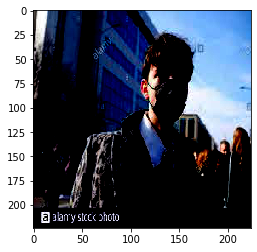

with_mask


In [18]:
plt.imshow(data[0])
plt.show()
print(labels[0])

In [19]:
len(data)

3833

In [21]:
#labels
print(len(labels))

3833


# BUILDING MODEL

In [27]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [31]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# STRATIFIED SPLIT FOR MAINTAINING UNIFORMITY

In [32]:
(trainX, testX, trainY, testY) = train_test_split(data, 
                                                  labels,
                                                  test_size=0.20, 
                                                  stratify=labels, 
                                                  random_state=69)

# DATA AUGMENTATION 

In [33]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")


In [34]:
baseModel = MobileNetV2(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))


9412608/9406464 [==============================] - 3s 0us/step


# EPOCH USED IS 1 TO REDUCE TIME. USE MORE EPOCH FOR BETTER ACCURACY

In [41]:
LEARNING_RATE = 1e-4
epoch = 1
batch_size = 32

In [36]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(rate = 1 - 0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [37]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [38]:
for layer in baseModel.layers:
    layer.trainable = False

In [39]:
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / epoch)
model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

In [42]:
Hist = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
              steps_per_epoch=len(trainX) // batch_size,
              validation_data=(testX, testY),
              validation_steps=len(testX) // batch_size,
              epochs=epoch)

95/95 [==============================] - 92s 972ms/step - loss: 0.1009 - accuracy: 0.9644 - val_loss: 0.0566 - val_accuracy: 0.9883


In [43]:
predIdxs = model.predict(testX, batch_size=batch_size)

In [44]:
predIdxs

array([[2.4919678e-03, 9.9750805e-01],
       [9.9912244e-01, 8.7755983e-04],
       [6.1335326e-03, 9.9386650e-01],
       ...,
       [1.2782462e-01, 8.7217540e-01],
       [9.8816407e-01, 1.1835903e-02],
       [3.9947322e-03, 9.9600524e-01]], dtype=float32)